# Chase Topic Modeling

In [ ]:
import pandas as pd 
import gensim
from gensim import corpora,models

C:\Users\AdaLi\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Preprocessing 

In [ ]:
# Read scraped csv of chase mobile app 
df = pd.read_csv("2015-2021_Chase_Rev.csv")
df

,Unnamed: 0,user,date,title,text,rating,year,month
0,0,dangityourecute,2018-08-31,I love the chase app,I’ve been using the app for over 4 years now a...,5,2018,8
1,1,*dude1.0*,2020-06-17,Terrible Customer Service and App,"First of all I rarely leave negative reviews, ...",1,2020,6
2,2,cdjewell.net,2021-03-07,Great but missing one key feature,I have an embarrassing number of Chase account...,4,2021,3
3,3,Zoeyxoxoxo,2020-06-03,If I could I’d put no stars,This app is TRASH. Matter of fact throw out th...,1,2020,6
4,4,Serge s...,2020-07-07,"It's excellent, packed with technology",I have done a review of the chase app over a y...,5,2020,7
...,...,...,...,...,...,...,...,...
53663,53663,Csmithincin,2015-10-05,"Reliable, innovative and user friendly","Reliable, innovative and user friendly. Best b...",5,2015,10
53664,53664,Adam sefchovich,2015-10-05,Great app,Wish it included more rewards information rega...,5,2015,10
53665,53665,Goofy4u21,2015-10-04,Amazing,Chase app has gotten better and better. Love t...,5,2015,10
53666,53666,rmb317,2015-10-04,Terrific!,Great app! Very user-friendly and very few iss...,5,2015,10


In [ ]:
#convert all review text into list format
docs = df['text'].tolist()
docs[0]

'I’ve been using the app for over 4 years now and I’ve had no problems using anything. Mobile deposit checks works great, everything gets updated and I can pay off things whenever. The only problem I had was recently where I got a new phone number and my old number got disconnected, and I didn’t go into my chase app or the chase website to change it right away. I got locked out of my account for a total of 5 days. I called chase and got transferred twice and then had to wait for a call from one of them which I missed. Just because the only way to confirm it’s me is to send a text to my phone number that’s on chase which was my old number (which is disconnected). They kept saying that’s the only way to get into chase. This only got resolved because I got a “fraudulent activity” email. So I call them and then they finally confirm it’s me. And I’m able to change my phone number this way and get a new password for my chase app. That was definitely a hassle which was my fault in the end. Bu

### LDA and LSA per 2020-2021 by Star Rating

In [ ]:
#create df for the years 2020-2021
since2020= df.loc[(df.year >=2020)] 
del since2020['Unnamed: 0'] #delete unused col

fourFive=since2020.loc[since2020.rating >= 4] #create df for ratings over and including 4
pos_jan_mar_2020=since2020.loc[(since2020.month <= 3) & (since2020.year == 2020) & (since2020.rating >=4)]
pos_apr_jun_2020=since2020.loc[(since2020.month > 3) & (since2020.month <= 6)& (since2020.year == 2020) & (since2020.rating >=4)]
pos_jul_sep_2020=since2020.loc[(since2020.month > 6) & (since2020.month <= 9)& (since2020.year == 2020) & (since2020.rating >=4)]
pos_oct_dec_2020=since2020.loc[(since2020.month > 9) & (since2020.month <= 12)& (since2020.year == 2020) & (since2020.rating >=4)]
pos_jan_mar_2021=since2020.loc[(since2020.month <= 3) &  (since2020.year == 2021) & (since2020.rating >=4)]


oneTwo=since2020.loc[since2020.rating <= 2] #create df for ratings under and including 2
neg_jan_mar_2020=since2020.loc[(since2020.month <= 3) & (since2020.year == 2020) & (since2020.rating <=2)]
neg_apr_jun_2020=since2020.loc[(since2020.month > 3) & (since2020.month <= 6)& (since2020.year == 2020) & (since2020.rating <=2)]
neg_jul_sep_2020=since2020.loc[(since2020.month > 6) & (since2020.month <= 9)& (since2020.year == 2020) & (since2020.rating <=2)]
neg_oct_dec_2020=since2020.loc[(since2020.month > 9) & (since2020.month <= 12)& (since2020.year == 2020) & (since2020.rating <=2)]
neg_jan_mar_2021=since2020.loc[(since2020.month <= 3) &  (since2020.year == 2021) & (since2020.rating <=2)]




#### Creating Function for LDA and LSA

In [ ]:
# import libraries to tokenize reviews
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer # Lemmatize the documents
from gensim.models import Phrases # Compute bigrams
from gensim.corpora import Dictionary # Remove rare and common tokens
import numpy as np
from gensim.models import LdaModel # Train LDA model.

stop_words = stopwords.words('english')
stop_words.extend(['app','chase','bank','banking'])

def lda_and_lsa(x): #creating function for lda model with x being the df 
    docs = x['text'].tolist() #creating list out of review column
    tokenizer = RegexpTokenizer(r'\w+') # Split the documents into tokens.
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

     # Remove numbers, but not words that contain numbers
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]   
      # Remove stopwords
    docs = [[token for token in doc if token not in stop_words] for doc in docs]
      # Remove words that are only one character
    docs = [[token for token in doc if len(token) > 1] for doc in docs]
    #lemmatizer to make words the same no matter the tense, plural, etc
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

      # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=10)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token: # Token is a bigram, add to document.
                docs[idx].append(token)

    # Create a dictionary representation of the documents
    dictionary = Dictionary(docs)
    
    # This step would be necessary in larger text
    dictionary.filter_extremes(no_below=10, no_above=0.7)
    
    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    # generate a unique token list 
    sort_token = sorted(dictionary.items(),key=lambda k:k[0], reverse = False)
    unique_token = [token.encode('utf8') for (ID,token) in sort_token]
    
    matrix = gensim.matutils.corpus2dense(corpus,num_terms=len(dictionary),dtype = 'int')
    matrix = matrix.T #transpose the matrix 

    #convert the numpy matrix into pandas data frame
    matrix_df = pd.DataFrame(matrix, columns=unique_token)
    
    # Set training parameters.
    num_topics = 5
    chunksize = 2000
    passes = 20
    iterations = 100
    eval_every = 1  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    #create lda model based on details
    lda = LdaModel(
      corpus=corpus,
      id2word=id2word,
      chunksize=chunksize,
      alpha='auto',
      eta='auto',
      iterations=iterations,
      num_topics=num_topics,
      passes=passes,
      eval_every=eval_every
    )
    lda.print_topics(5) #V matrix, topic matrix
    import re #print topics and their words
    for i,topic in lda.print_topics(10): #10 words for 5 topics
        print(f'LDA: Top 5 words for topic #{i+1}:')
        print(",".join(re.findall('".*?"',topic)))
        print('\n')
    top_topics = lda.top_topics(corpus) 
    # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
    avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
    print('LDA: Average topic coherence: %.4f.' % avg_topic_coherence)
    from pprint import pprint
    pprint(top_topics)
   
    for index, score in sorted(lda[corpus[30]], key=lambda tup: -1*tup[1]):
        print("\n LDA Score: {}\t \nTopic: {}".format(score, lda.print_topic(index, 10)))

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    # Tfidf Transformation 
    tfidf = models.TfidfModel(corpus) #fit tfidf model
    corpus_tfidf = tfidf[corpus]      #transform tfidf model
    
    # Train LSI model.
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=5)
    import re
    for i,topic in lsi.print_topics(10):
        print(f'LSI: Top 5 words for topic #{i+1}:')
        print(",".join(re.findall('".*?"',topic)))
        print('\n')
    for index, score in sorted(lsi[corpus_tfidf[30]], key=lambda tup: -1*tup[1]):
        print("\nLSI Score: {}\t \nTopic: {}".format(score, lsi.print_topic(index, 10)))

In [ ]:
lda_ff = lda(x=fourFive)

LDA: Top 5 words for topic #1:
"love","app","chase","everything","bank","need","make","awesome","banking","easy"


LDA: Top 5 words for topic #2:
"app","great","banking","easy","love","check","navigate","easy_navigate","deposit","keep"


LDA: Top 5 words for topic #3:
"app","account","card","like","money","chase","credit","balance","time","see"


LDA: Top 5 words for topic #4:
"easy","use","easy_use","app","user","friendly","user_friendly","love","good","convenient"


LDA: Top 5 words for topic #5:
"chase","bank","service","best","customer","always","thank","banking","great","year"


LDA: Average topic coherence: -2.8452.
[([(0.042225022, 'app'),
   (0.0369627, 'account'),
   (0.02092625, 'card'),
   (0.016406182, 'like'),
   (0.016179346, 'money'),
   (0.015886933, 'chase'),
   (0.015463344, 'credit'),
   (0.013414794, 'balance'),
   (0.012964208, 'time'),
   (0.012266889, 'see'),
   (0.012106936, 'would'),
   (0.011630807, 'one'),
   (0.011547783, 'check'),
   (0.011282988, 'update')

In [ ]:
lda_ot = lda(oneTwo)

LDA: Top 5 words for topic #1:
"transaction","see","app","account","much","need","go","one","amount","balance"


LDA: Top 5 words for topic #2:
"app","update","new","io","phone","use","iphone","version","work","chase"


LDA: Top 5 words for topic #3:
"app","bank","chase","service","customer","one","would","account","customer_service","well"


LDA: Top 5 words for topic #4:
"app","time","every","update","fix","password","log","open","chase","every_time"


LDA: Top 5 words for topic #5:
"account","chase","card","bank","money","time","credit","pay","payment","check"


LDA: Average topic coherence: -2.5032.
[([(0.032271855, 'account'),
   (0.030350521, 'chase'),
   (0.020886464, 'card'),
   (0.019753765, 'bank'),
   (0.017380819, 'money'),
   (0.013121385, 'time'),
   (0.012572783, 'credit'),
   (0.010922496, 'pay'),
   (0.0107051665, 'payment'),
   (0.009725479, 'check'),
   (0.009209403, 'charge'),
   (0.009049464, 'get'),
   (0.0086014895, 'one'),
   (0.008416333, 'call'),
   (0.0084098

In [ ]:
# Important topics in the positive reviews
weight_p = []
word_p = []
for i in lda_ff.top_topics:
    for w in i[0]:
        weight_p.append(w[0])
        word_p.append(w[1])
list_p = dict(zip(word_p,weight_p))
list_p_s = sorted(list_p, key = lambda x:x[1], reverse = True)[:20]

#Important topics in the negative reviews
weight_n = []
word_n = []
for i in lda_ot.top_topics:
    for w in i[0]:
        weight_n.append(w[0])
        word_n.append(w[1])
list_n = dict(zip(word_n,weight_n))
list_n_s = sorted(list_n, key = lambda x:x[1], reverse = True)[:20]

In [ ]:
list_p_s_c = [i for i in list_p_s if i not in list_n_s]
list_n_s_c = [i for i in list_n_s if i not in list_p_s]

### Negative by 3 Month invervals

In [ ]:
lda_njm0 = lda(neg_jan_mar_2020)

LDA: Top 5 words for topic #1:
"app","account","update","crash","charge","business","phone","one","time","personal"


LDA: Top 5 words for topic #2:
"app","card","chase","credit","work","credit_card","get","bank","customer","transaction"


LDA: Top 5 words for topic #3:
"app","check","deposit","bank","please","fix","keep","mobile","pay","please_fix"


LDA: Top 5 words for topic #4:
"chase","account","balance","payment","fee","branch","year","show","bank","never"


LDA: Top 5 words for topic #5:
"app","time","every","update","every_time","log","password","try","crash","never"


LDA: Average topic coherence: -4.1325.
[([(0.11911069, 'app'),
   (0.057073038, 'check'),
   (0.041683845, 'deposit'),
   (0.0412253, 'bank'),
   (0.035002813, 'please'),
   (0.032983165, 'fix'),
   (0.03203189, 'keep'),
   (0.029606063, 'mobile'),
   (0.024342733, 'pay'),
   (0.020232122, 'please_fix'),
   (0.020091666, 'work'),
   (0.018303318, 'crashing'),
   (0.0159337, 'need'),
   (0.015739234, 'money'),
   

In [ ]:
lda_naj0 = lda(neg_apr_jun_2020)

LDA: Top 5 words for topic #1:
"check","bank","card","deposit","account","app","chase","credit","credit_card","mobile"


LDA: Top 5 words for topic #2:
"app","update","password","open","keep","use","id","even","new","even_open"


LDA: Top 5 words for topic #3:
"app","chase","work","use","find","one","phone","time","bank","card"


LDA: Top 5 words for topic #4:
"app","time","update","crash","open","every","chase","every_time","get","recent"


LDA: Top 5 words for topic #5:
"account","chase","customer","transaction","service","time","bank","payment","month","money"


LDA: Average topic coherence: -3.4696.
[([(0.056482058, 'account'),
   (0.04938493, 'chase'),
   (0.034200612, 'customer'),
   (0.029233571, 'transaction'),
   (0.028011072, 'service'),
   (0.024420355, 'time'),
   (0.024238834, 'bank'),
   (0.022515662, 'payment'),
   (0.02236139, 'month'),
   (0.022068044, 'money'),
   (0.020557076, 'customer_service'),
   (0.019967474, 'make'),
   (0.017966943, 'app'),
   (0.015495185, 'g

In [ ]:
lda_njs0 = lda(neg_jul_sep_2020)

LDA: Top 5 words for topic #1:
"every","time","log","every_time","app","password","annoying","let","cannot","use"


LDA: Top 5 words for topic #2:
"account","chase","service","bank","customer","money","app","one","customer_service","new"


LDA: Top 5 words for topic #3:
"app","card","account","get","time","need","always","use","credit","see"


LDA: Top 5 words for topic #4:
"app","chase","update","check","bank","time","fix","please","month","deposit"


LDA: Top 5 words for topic #5:
"app","id","update","new","use","look","password","face","work","face_id"


LDA: Average topic coherence: -4.1541.
[([(0.060293186, 'account'),
   (0.04946932, 'chase'),
   (0.03862333, 'service'),
   (0.03248245, 'bank'),
   (0.02842428, 'customer'),
   (0.024079742, 'money'),
   (0.022860376, 'app'),
   (0.019810297, 'one'),
   (0.01967916, 'customer_service'),
   (0.018079031, 'new'),
   (0.017179653, 'back'),
   (0.015522127, 'update'),
   (0.015275858, 'time'),
   (0.015255574, 'fee'),
   (0.014624314,

In [ ]:
lda_nod0 = lda(neg_oct_dec_2020)

LDA: Top 5 words for topic #1:
"account","new","card","update","app","see","screen","please","credit","make"


LDA: Top 5 words for topic #2:
"app","phone","password","get","number","chase","id","io","log","face"


LDA: Top 5 words for topic #3:
"app","transaction","chase","update","like","check","use","fix","new","change"


LDA: Top 5 words for topic #4:
"app","update","time","every","use","chase","even","every_time","work","need"


LDA: Top 5 words for topic #5:
"chase","account","bank","customer","service","day","payment","pay","money","time"


LDA: Average topic coherence: -2.9203.
[([(0.06656764, 'chase'),
   (0.051721282, 'account'),
   (0.047728714, 'bank'),
   (0.038239453, 'customer'),
   (0.033026163, 'service'),
   (0.03235153, 'day'),
   (0.029886063, 'payment'),
   (0.028053852, 'pay'),
   (0.025176335, 'money'),
   (0.024575936, 'time'),
   (0.023673007, 'customer_service'),
   (0.020021217, 'bill'),
   (0.01894177, 'call'),
   (0.018054875, 'deposit'),
   (0.017772557, '

In [ ]:
lda_njm1 = lda(neg_jan_mar_2021)

LDA: Top 5 words for topic #1:
"app","phone","io","use","chase","new","iphone","update","work","longer"


LDA: Top 5 words for topic #2:
"account","bank","card","chase","money","get","payment","like","go","credit"


LDA: Top 5 words for topic #3:
"app","chase","id","io","one","face","option","use","mobile","work"


LDA: Top 5 words for topic #4:
"app","update","time","every","use","chase","customer","password","need","unable"


LDA: Top 5 words for topic #5:
"app","chase","bank","customer","iphone","service","new","phone","well","user"


LDA: Average topic coherence: -2.3331.
[([(0.07853472, 'app'),
   (0.061806835, 'phone'),
   (0.041379258, 'io'),
   (0.03858865, 'use'),
   (0.033250526, 'chase'),
   (0.030122511, 'new'),
   (0.027638847, 'iphone'),
   (0.025226662, 'update'),
   (0.024533516, 'work'),
   (0.01845143, 'longer'),
   (0.016877519, 'bank'),
   (0.015838806, 'get'),
   (0.015447879, 'older'),
   (0.014655683, 'check'),
   (0.014460511, 'version'),
   (0.012922363, 'depos

### Positive by 3 Month invervals

In [ ]:
lda_pjm0 = lda(pos_jan_mar_2020)

LDA: Top 5 words for topic #1:
"app","chase","love","bank","easy","account","banking","check","thank","need"


LDA: Top 5 words for topic #2:
"chase","bank","banking","year","make","thanks","easy","love","app","always"


LDA: Top 5 words for topic #3:
"chase","app","issue","would","always","nice","helpful","balance","good","like"


LDA: Top 5 words for topic #4:
"service","great","chase","app","customer","user","friendly","bank","customer_service","user_friendly"


LDA: Top 5 words for topic #5:
"use","easy","easy_use","card","credit","app","account","feature","credit_card","great"


LDA: Average topic coherence: -4.0035.
[([(0.12424001, 'app'),
   (0.0710861, 'chase'),
   (0.07005924, 'love'),
   (0.042901967, 'bank'),
   (0.04131632, 'easy'),
   (0.03129817, 'account'),
   (0.027700108, 'banking'),
   (0.024056623, 'check'),
   (0.02270028, 'thank'),
   (0.022148896, 'need'),
   (0.02164512, 'time'),
   (0.021391738, 'best'),
   (0.020598505, 'everything'),
   (0.019329129, 'great'),

In [ ]:
lda_paj0 = lda(pos_apr_jun_2020)

LDA: Top 5 words for topic #1:
"chase","bank","service","customer","app","banking","love","time","thank","always"


LDA: Top 5 words for topic #2:
"chase","love","app","easy","make","use","help","thanks","bank","banking"


LDA: Top 5 words for topic #3:
"easy","use","app","easy_use","bank","good","chase","best","love","great"


LDA: Top 5 words for topic #4:
"app","great","user","account","update","friendly","use","user_friendly","transaction","money"


LDA: Top 5 words for topic #5:
"app","card","credit","pay","chase","credit_card","account","money","bill","much"


LDA: Average topic coherence: -3.8379.
[([(0.09614066, 'chase'),
   (0.057026118, 'bank'),
   (0.049932797, 'service'),
   (0.03806232, 'customer'),
   (0.03521224, 'app'),
   (0.034401238, 'banking'),
   (0.028395388, 'love'),
   (0.027618341, 'time'),
   (0.026449656, 'thank'),
   (0.02498715, 'always'),
   (0.021642702, 'year'),
   (0.01910016, 'customer_service'),
   (0.018753616, 'great'),
   (0.018141592, 'deposit'),


In [ ]:
lda_pjs0 = lda(pos_jul_sep_2020)

LDA: Top 5 words for topic #1:
"app","great","need","account","get","love","time","card","update","one"


LDA: Top 5 words for topic #2:
"app","balance","like","always","feature","keep","would","transaction","great","love"


LDA: Top 5 words for topic #3:
"easy","use","app","easy_use","love","chase","convenient","friendly","user","user_friendly"


LDA: Top 5 words for topic #4:
"chase","bank","account","year","app","using","money","banking","check","really"


LDA: Top 5 words for topic #5:
"chase","service","banking","bank","customer","best","app","good","customer_service","problem"


LDA: Average topic coherence: -3.6867.
[([(0.06814931, 'chase'),
   (0.06652315, 'service'),
   (0.05577072, 'banking'),
   (0.054063827, 'bank'),
   (0.047736347, 'customer'),
   (0.041337647, 'best'),
   (0.041071355, 'app'),
   (0.037090294, 'good'),
   (0.032940924, 'customer_service'),
   (0.030182064, 'problem'),
   (0.028699774, 'never'),
   (0.027255392, 'thank'),
   (0.026184069, 'always'),
   (0

In [ ]:
lda_pod0 = lda(pos_oct_dec_2020)

LDA: Top 5 words for topic #1:
"banking","app","need","account","friendly","user","user_friendly","mobile","make","everything"


LDA: Top 5 words for topic #2:
"service","easy","chase","use","easy_use","customer","app","bank","customer_service","always"


LDA: Top 5 words for topic #3:
"app","chase","like","easy","bank","use","great","love","money","using"


LDA: Top 5 words for topic #4:
"app","love","check","chase","make","easy","see","balance","time","well"


LDA: Top 5 words for topic #5:
"chase","bank","card","love","account","thank","new","app","best","credit"


LDA: Average topic coherence: -3.6435.
[([(0.06660949, 'app'),
   (0.05920674, 'love'),
   (0.05490908, 'check'),
   (0.039997287, 'chase'),
   (0.03627531, 'make'),
   (0.035224106, 'easy'),
   (0.034102816, 'see'),
   (0.03217472, 'balance'),
   (0.028131055, 'time'),
   (0.027994907, 'well'),
   (0.027095148, 'account'),
   (0.02537237, 'would'),
   (0.024427658, 'please'),
   (0.023996811, 'much'),
   (0.023230093, 'b

In [ ]:
lda_pjm1 = lda(pos_jan_mar_2021)

LDA: Top 5 words for topic #1:
"app","bank","best","chase","love","need","one","like","transaction","great"


LDA: Top 5 words for topic #2:
"easy","use","easy_use","app","navigate","convenient","easy_navigate","chase","love","check"


LDA: Top 5 words for topic #3:
"service","thank","chase","customer","bank","app","good","great","excellent","customer_service"


LDA: Top 5 words for topic #4:
"love","chase","app","banking","friendly","user","user_friendly","online","card","make"


LDA: Top 5 words for topic #5:
"chase","account","bank","always","great","app","money","year","helpful","alert"


LDA: Average topic coherence: -3.9136.
[([(0.10470915, 'app'),
   (0.055489495, 'bank'),
   (0.04992082, 'best'),
   (0.039792687, 'chase'),
   (0.039165422, 'love'),
   (0.03075383, 'need'),
   (0.02523595, 'one'),
   (0.025227072, 'like'),
   (0.025054395, 'transaction'),
   (0.02495317, 'great'),
   (0.024310589, 'check'),
   (0.021650232, 'account'),
   (0.020615017, 'keep'),
   (0.020552294, 

In [ ]:
# weights total in the negative list
wordn = []
word1 = 0
for d in ['jm0','aj0','js0','od0','jm1']:
    for s in ['n','p']:
        exec('ld = lda_{}{}.top_topics'.format(s,d))
        for i in ld:
            for w in i[0]:
                if w[1] == list_n_s_c[5]:
                    word1 += w[0]
    wordn.append(word1)

In [ ]:
wordnm = [i*10 for i in wordn]
wordnm

[0.6250106543302536,
 1.0201923921704292,
 1.1785579286515713,
 1.1785579286515713,
 1.1785579286515713]

In [ ]:
list_n_s_c[5]

'crash'

In [ ]:
# weights total in the positive list
wordp = ['jm0','aj0','js0','od0','jm1']
word1 = 0
for d in ['jm0','aj0','js0','od0','jm1']:
    for s in ['n','p']:
        exec('ld = lda_{}{}.top_topics'.format(s,d))
        for i in ld:
            for w in i[0]:
                if w[1] == list_p_s_c[6]:
                    word1 += w[0]
                    
    wordp.append(word1)

In [ ]:
wordpm = [i*10 for i in wordp]
wordpm

[0.26968395337462425,
 0.4720677062869072,
 0.718845073133707,
 1.2045654095709324,
 1.6045196168124676]

In [ ]:
list_p_s_c[6]

'user_friendly'

In [ ]:
# Get ratings
fourFive=since2020.loc[since2020.rating >= 4] #create df for ratings over and including 4
jan_mar_2020=since2020.loc[(since2020.month <= 3) & (since2020.year == 2020)]['rating'].tolist()
apr_jun_2020=since2020.loc[(since2020.month > 3) & (since2020.month <= 6)& (since2020.year == 2020) ]['rating'].tolist()
jul_sep_2020=since2020.loc[(since2020.month > 6) & (since2020.month <= 9)& (since2020.year == 2020)]['rating'].tolist()
oct_dec_2020=since2020.loc[(since2020.month > 9) & (since2020.month <= 12)& (since2020.year == 2020)]['rating'].tolist()
jan_mar_2021=since2020.loc[(since2020.month <= 3) &  (since2020.year == 2021)]['rating'].tolist()


In [ ]:
# Average ratings for every three month
import numpy as np
jan_mar_2020_r = np.average(jan_mar_2020)
apr_jun_2020_r = np.average(apr_jun_2020)
jul_sep_2020_r = np.average(jul_sep_2020)
oct_dec_2020_r = np.average(oct_dec_2020)
jan_mar_2021_r = np.average(jan_mar_2021)
r = []
r.append(jan_mar_2020_r)
r.append(apr_jun_2020_r)
r.append(jul_sep_2020_r)
r.append(oct_dec_2020_r)
r.append(jan_mar_2021_r)

In [ ]:
r

[3.6632034632034634,
 3.533869885982562,
 3.351818181818182,
 2.9261241970021414,
 3.3695817490494298]

In [ ]:
import matplotlib.pyplot as plt

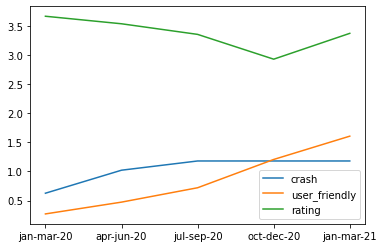

In [ ]:
x = ['jan-mar-20','apr-jun-20','jul-sep-20','oct-dec-20','jan-mar-21']
plt.plot(x,wordnm, label = "crash")
plt.plot(x,wordpm, label = "user_friendly")
plt.plot(x,r, label = "rating")
plt.legend()
plt.show()